# 2. Exploratory Data Analysis

In this notebook, we shall use the data collected from the weather API, and conduct some preliminary analysis for feature engineering.

### 2.1 Imports

As usual, we import the usual packages. We shall also import the data sets for analysis

In [1]:
#import data handling
import numpy as np
import pandas as pd
import datetime, time, calendar
import math

#import viz packages
import seaborn as sns
import matplotlib.pyplot as plt

#import spatial viz packages
import geopandas as gpd
import folium

# import contextily as cx
# import xyzservices.providers as xyz
# from shapely.geometry import Point
# from geopy import distance
# import pysal
# from pysal.lib import weights

In [2]:
weather_data = pd.read_csv('../data/00_weatherdata_full.csv')
station_data = pd.read_csv('../data/00_stationdata.csv')

In [3]:
weather_data.tail()

,timestamp,station_id,temp,rh,wind_dir,wind_spd,rain,id,name,location,latitude,longitude
3178156,2022-04-30 23:35:00+08:00,S50,26.72,88.16,115.8,1.12,0.0,S50,Clementi Road,"{'latitude': 1.3337, 'longitude': 103.7768}",1.3337,103.7768
3178157,2022-04-30 23:40:00+08:00,S50,26.58,89.42,42.0,0.90,0.0,S50,Clementi Road,"{'latitude': 1.3337, 'longitude': 103.7768}",1.3337,103.7768
3178158,2022-04-30 23:45:00+08:00,S50,26.56,90.24,279.8,1.12,0.0,S50,Clementi Road,"{'latitude': 1.3337, 'longitude': 103.7768}",1.3337,103.7768
3178159,2022-04-30 23:50:00+08:00,S50,26.82,88.96,212.6,1.04,0.0,S50,Clementi Road,"{'latitude': 1.3337, 'longitude': 103.7768}",1.3337,103.7768
3178160,2022-04-30 23:55:00+08:00,S50,27.10,87.56,14.6,0.80,0.0,S50,Clementi Road,"{'latitude': 1.3337, 'longitude': 103.7768}",1.3337,103.7768


In [4]:
station_data.head()

,id,name,location,latitude,longitude
0,S77,Alexandra Road,"{'latitude': 1.2937, 'longitude': 103.8125}",1.2937,103.8125
1,S109,Ang Mo Kio Avenue 5,"{'latitude': 1.3764, 'longitude': 103.8492}",1.3764,103.8492
2,S90,Bukit Timah Road,"{'latitude': 1.3191, 'longitude': 103.8191}",1.3191,103.8191
3,S114,Choa Chu Kang Avenue 4,"{'latitude': 1.38, 'longitude': 103.73}",1.3800,103.7300
4,S50,Clementi Road,"{'latitude': 1.3337, 'longitude': 103.7768}",1.3337,103.7768


### 2.2 Descrptive analysis on Data Frame

Here, we take a look at some simple descriptive analytics on the data frame.
In particular, we will look at a few aspects:
* Location of sensors
* Temperature Distribution
* Relative Humidity Distribution
* Wind Direction & Speed - Distribution
* Amount of Rain Collected

#### 2.2.1 Plotting Location of Sensors

First, we shall use the Geopandas functions to plot the location of the sensors.

* https://python-graph-gallery.com/map-read-geojson-with-python-geopandas
* https://python-graph-gallery.com/312-add-markers-on-folium-map
* https://python-visualization.github.io/folium/modules.html

use tiles = "CartoDB dark_matter' for darkmode base map

In [5]:
def plot_sensors(df):
    #prepare Stations data
    stations_selected = df[['id','name','latitude','longitude']]
    stations_selected = stations_selected.drop_duplicates()
    stations_selected = stations_selected.dropna()
    stations_selected = stations_selected.reset_index()
    stations_selected = stations_selected.drop(columns = ['index'])

    # Make an empty map
    m = folium.Map(location=[1.3469947058823533, 103.82489470588237],
                   tiles="OpenStreetMap",
                   zoom_start=11.5,
                   zoom_control=False,
                   scrollWheelZoom=False,
                   dragging=False
                  )

    # Add marker based on location of stations
    for i in range(0,len(stations_selected)):
        folium.Marker(location = [stations_selected.iloc[i]['latitude'], stations_selected.iloc[i]['longitude']],
                     popup = stations_selected.iloc[i]['name'],
                     no_wrap = True
                     ).add_to(m)

    # Save to local drive
    m.save('../presentation/SG_Stations_map.html')

    # Show the map
    return m

plot_sensors(weather_data)

From the map, we can see that we have 13 stations spread across singapore. While we have more data sources, these 13 stations are suffiently spread out for the purposes of predicting weather trends across Singapore. 

We do note that, however, some areas are less represented. These come in the form of lack of data collection, data loggers, or a stable pipeline for data collection. Namely, these areas of interest are:
* Sentosa Island
* Jurong Island & Taman Jurong
* Sengkang/Punggol Settlement area
* Yishun Town

While more work could be put into identifying data sources, we shall proceed optimistically with the current data set to predict presence of rain further.

#### 2.2.2 Describing Temperature Trends
* YoY Daily Averaged comparison
* Year-Month heatmap, color == red, depth == monthly-average temp

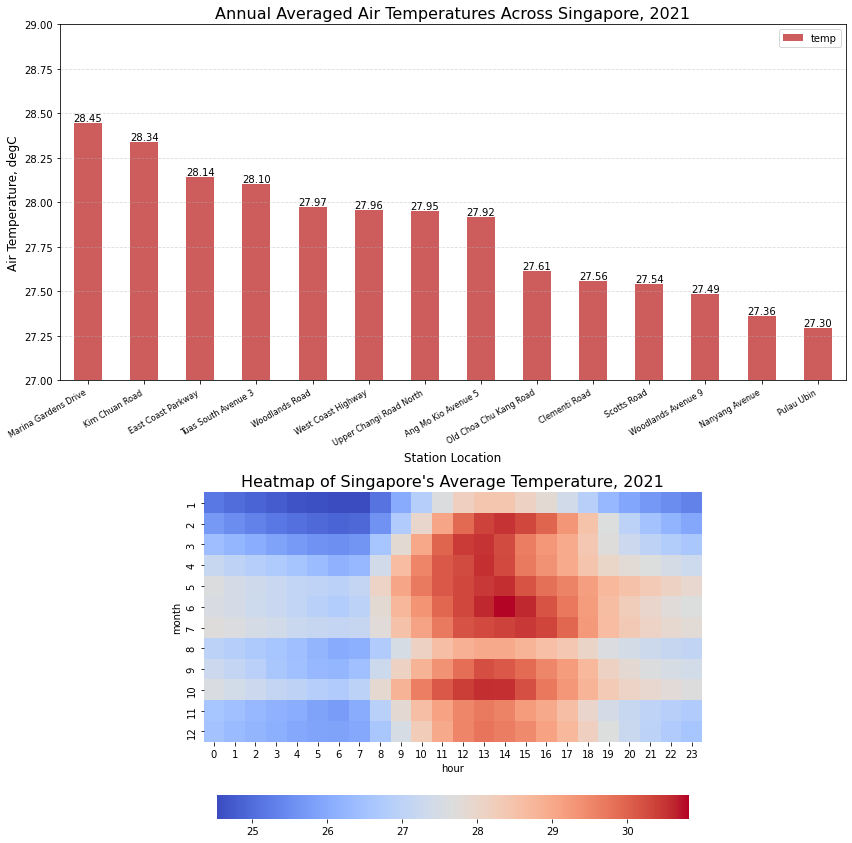

In [6]:
def temp_analysis(df, read_data = False):
    
    filepath = '../data/02_tempdata_daily.csv'
    
    if read_data == True:
        temp_data = pd.read_csv(filepath)
        temp_data['timestamp'] = pd.to_datetime(temp_data['timestamp'])
    else:
        # Filter out relevant 
        temp_data = df.loc[:,['timestamp','station_id','name','temp']]
        temp_data['timestamp'] = pd.to_datetime(temp_data['timestamp'])

        # Promote station_id & timestamp
        temp_data = temp_data.sort_values(by = ['station_id','timestamp'])
        temp_data = temp_data.set_index(keys = ['station_id','timestamp'])

        # Resample - Daily averaged temp
        temp_data = temp_data.groupby(['station_id','name']+[pd.Grouper(freq='h', level=-1)]).mean()
        temp_data = temp_data.reset_index()

        temp_data.to_csv(filepath)
        temp_data['timestamp'] = pd.to_datetime(temp_data['timestamp'])
        
        
                
    # Timestamp - get yearnum & monNum
    temp_data['year'] = temp_data['timestamp'].dt.year
    temp_data['month'] = temp_data['timestamp'].dt.month
    temp_data['hour'] = temp_data['timestamp'].dt.hour
#     temp_data['yearmonth'] = temp_data['timestamp'].dt.strftime('%Y-%m')
    
    #Group for anualized temp
    temp_data_sg_avg = temp_data[['year','station_id','name','temp']]
    temp_data_sg_avg = temp_data_sg_avg.groupby(by = ['year','station_id','name']).mean()
    temp_data_sg_avg = temp_data_sg_avg.reset_index()
    temp_data_sg_avg = temp_data_sg_avg[temp_data_sg_avg['year'] == 2021]
    temp_data_sg_avg = temp_data_sg_avg.sort_values(by = 'temp', ascending = False)
    
    # Group for heatmap
    temp_data_heatmap =  temp_data[['year','month','hour','temp']]
    temp_data_heatmap = temp_data_heatmap.groupby(by = ['year','month','hour']).mean()
    temp_data_heatmap = temp_data_heatmap.reset_index()
    temp_data_heatmap = temp_data_heatmap[temp_data_heatmap['year'] == 2021]
    temp_data_heatmap = temp_data_heatmap.drop(columns = ['year'])
    temp_data_heatmap = temp_data_heatmap.pivot(index = 'month',
                                                columns = 'hour',
                                                values = 'temp')
    
    
    # Plot Values
    fig, ax = plt.subplots(nrows = 2,
                           ncols = 1,
                           figsize = (12,12))

    # Plot bar chart of avg temp. 
    chart = temp_data_sg_avg.plot.bar(x = 'name', y = 'temp', color = 'indianred', ax = ax[0]);
    chart.grid(axis = 'y', linestyle = '--', alpha = 0.45)
    chart.set_xticklabels(chart.get_xticklabels(),
                         rotation = 30,
                         horizontalalignment = 'right',
                         fontsize = 8);
    
    chart.bar_label(chart.containers[0], fmt = '%.2f');
    chart.set_xlabel('Station Location', fontsize = 12);
    chart.set_ylabel('Air Temperature, degC', fontsize = 12);
    chart.axis(ymin = 27, ymax = 29);
    chart.set_title('Annual Averaged Air Temperatures Across Singapore, 2021', fontsize = 16);
    chart.legend(loc = 'upper right');

    # plot heatmap
    sns.heatmap(temp_data_heatmap,
                cmap = 'coolwarm',
                cbar_kws = {'orientation': 'horizontal',
                           'pad': 0.15,
                           'shrink': 0.6},
                square = True,
                ax = ax[1]
               );
    plt.title("Heatmap of Singapore's Average Temperature, 2021", fontsize = 16)
    
    #format subplots
    fig.tight_layout()
    plt.show()
    
#     return temp_data_heatmap

temp_analysis(weather_data, read_data = True)

##### Initial Analysis - Temperature Trends

From the charts, we see a few trends
* The temperature sensor towards Marina Gardens Drive recorded the highest annual averaged temperature, with Kim Chuan Road being a close second.
    * For <u>Marina Gardens Drive</u>, one likely reason for the high temperature is due to the <u>proximity to the coastal shoreline</u>. This is consistent with Rank #3 East Coast Parkway with an annual average temperature of 28.13 degC.
    * For <u>Kim Chuan Road</u>, this sensor is located near an airbase, with <u>little vegetation and big areas of built environments</u>. It is likely that the lack of vegetation in this area leads to higher heat absorption, and hence higher average temperatures. 


Also, from the heat map, we see a few trends across 2021.
* The months of <u>January, Febuary and March</u> appear to have generally <u>low temperatures</u>.
* Conversely, the months of <u>May, June and July</u> features the <u>highest temperatures</u> across the year, specifically towards the end of the months.
    * This might be due to seasonal shifting winds, where the <i>La Nina and El Nino</i>, weather phenomenons where <u>prevailing winds bring dry, hot air </u>across the region, resulting in higher daily-averaged temperatures. 
    
    


#### 2.2.3 Describing Rain Trends

* Year-Month Heatmap, color depth by precip amount
* Hour of Day-Week of Year, color depth by precip amount

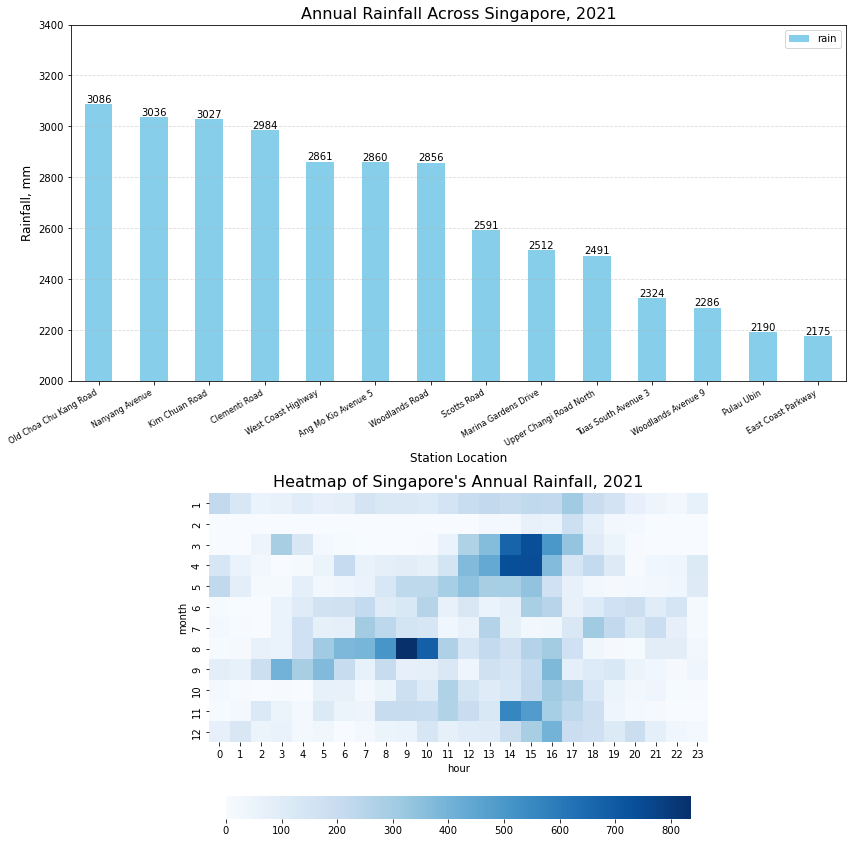

In [7]:
def rain_analysis(df, read_data = False):
    
    filepath = '../data/02_raindata_daily.csv'
    
    if read_data == True:
        rain_data = pd.read_csv(filepath)
        rain_data['timestamp'] = pd.to_datetime(rain_data['timestamp'])
    else:
        # Filter out relevant 
        rain_data = df.loc[:,['timestamp','station_id','name','rain']]
        rain_data['timestamp'] = pd.to_datetime(rain_data['timestamp'])

        # Promote station_id & timestamp
        rain_data = rain_data.sort_values(by = ['station_id','timestamp'])
        rain_data = rain_data.set_index(keys = ['station_id','timestamp'])

        # Resample - Daily averaged temp
        rain_data = rain_data.groupby(['station_id','name']+[pd.Grouper(freq='h', level=-1)]).sum()
        rain_data = rain_data.reset_index()

        rain_data.to_csv(filepath, index = False)
        rain_data['timestamp'] = pd.to_datetime(rain_data['timestamp'])
        
        
                
    # Timestamp - get yearnum & monNum
    rain_data['year'] = rain_data['timestamp'].dt.year
    rain_data['month'] = rain_data['timestamp'].dt.month
    rain_data['day'] = rain_data['timestamp'].dt.day
    rain_data['hour'] = rain_data['timestamp'].dt.hour
#     rain_data['yearmonth'] = rain_data['timestamp'].dt.strftime('%Y-%m')
    
    #Group for anualized rainfall
    rain_data_sg_sum = rain_data[['year','station_id','name','rain']]
    rain_data_sg_sum = rain_data_sg_sum.groupby(by = ['year','station_id','name']).sum()
    rain_data_sg_sum = rain_data_sg_sum.reset_index()
    rain_data_sg_sum = rain_data_sg_sum[rain_data_sg_sum['year'] == 2021]
    rain_data_sg_sum = rain_data_sg_sum.sort_values(by = 'rain', ascending = False)
    
    # Group for heatmap
    rain_data_heatmap =  rain_data[['year','month','hour','rain']]
    rain_data_heatmap = rain_data_heatmap.groupby(by = ['year','month','hour']).sum()
    rain_data_heatmap = rain_data_heatmap.reset_index()
    rain_data_heatmap = rain_data_heatmap[rain_data_heatmap['year'] == 2021]
    rain_data_heatmap = rain_data_heatmap.drop(columns = ['year'])
    rain_data_heatmap = rain_data_heatmap.pivot(index = 'month',
                                                columns = 'hour',
                                                values = 'rain')
    
    
    # Plot Values
    fig, ax = plt.subplots(nrows = 2,
                           ncols = 1,
                           figsize = (12,12))

    # Plot bar chart of avg temp. 
    chart = rain_data_sg_sum.plot.bar(x = 'name', y = 'rain', color = 'skyblue', ax = ax[0]);
    chart.grid(axis = 'y', linestyle = '--', alpha = 0.45)
    chart.set_xticklabels(chart.get_xticklabels(),
                         rotation = 30,
                         horizontalalignment = 'right',
                         fontsize = 8);
    
    chart.bar_label(chart.containers[0], fmt = '%d');
    chart.set_xlabel('Station Location', fontsize = 12);
    chart.set_ylabel('Rainfall, mm', fontsize = 12);
    chart.axis(ymin = 2000, ymax = 3400);
    chart.set_title('Annual Rainfall Across Singapore, 2021', fontsize = 16);
    chart.legend(loc = 'upper right');

    # plot heatmap
    sns.heatmap(rain_data_heatmap,
                cmap = 'Blues',
                cbar_kws = {'orientation': 'horizontal',
                           'pad': 0.15,
                           'shrink': 0.6},
                square = True,
                ax = ax[1]
               );
    plt.title("Heatmap of Singapore's Annual Rainfall, 2021", fontsize = 16)
    
    #format subplots
    fig.tight_layout()
    plt.show()
    
#     return rain_data_heatmap

rain_analysis(weather_data, read_data = True)

##### Describing Rain Trends
Similar to the temperature trends, we can observe a few trends.

* Firstly, we observe that <u>Old Choa Chu Kang Road and Nanyang Avenue</u> ranks one of the highest in terms of rainfall amount. One possible reason for this is due to the <u>surrounding mountaineous regions</u> at a regional level. To the west of Singapore lies the Sumatran islands of Indonesia, where a few mountain ranges stretch across the island. Given the intermonsoon winds blowing across the island, the conditions are highly favourable for rain as a result of Orographic lift, resulting in relief rains across the Sumatran islands, and subsequently rain clouds being blown towards the western areas of Singapore. 

* Secondly, we also observe <u> that the months of March, April and May</u> tend to have heavy rains towards the early afternoons. On the other hand, we also observe rainfall across the <u>mornings of August and September</u>. 
* Lastly, for the year of 2021, we notice <u>consistently wet weather across January, November, and December</u> where most hours <u>recorded non-zero amounts of rainfall across the months. </u>

#### 2.2.4 Describing Humidity

In this analysis, Relative Humidity (RH) is a measure of the amount of moisture in the atmosphere. Given a particular temperature (and pressure), air can hold a fixed amount of moisture. Beyond that amount and the moisture begins to 

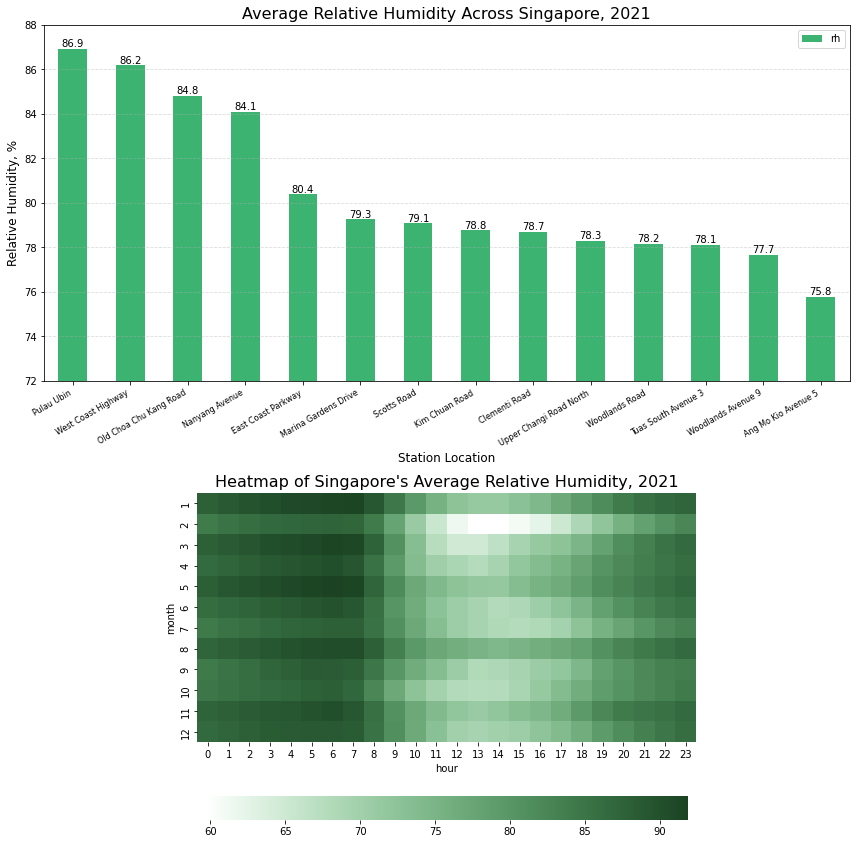

In [8]:
def humidity_analysis(df, read_data = False):
    
    filepath = '../data/02_humiddata_daily.csv'
    
    if read_data == True:
        hum_data = pd.read_csv(filepath)
        hum_data['timestamp'] = pd.to_datetime(hum_data['timestamp'])
    else:
        # Filter out relevant 
        hum_data = df.loc[:,['timestamp','station_id','name','rh']]
        hum_data['timestamp'] = pd.to_datetime(hum_data['timestamp'])

        # Promote station_id & timestamp
        hum_data = hum_data.sort_values(by = ['station_id','timestamp'])
        hum_data = hum_data.set_index(keys = ['station_id','timestamp'])

        # Resample - Daily averaged temp
        hum_data = hum_data.groupby(['station_id','name']+[pd.Grouper(freq='h', level=-1)]).mean()
        hum_data = hum_data.reset_index()

        hum_data.to_csv(filepath, index = False)
        hum_data['timestamp'] = pd.to_datetime(hum_data['timestamp'])
        
        
                
    # Timestamp - get yearnum & monNum
    hum_data['year'] = hum_data['timestamp'].dt.year
    hum_data['month'] = hum_data['timestamp'].dt.month
    hum_data['day'] = hum_data['timestamp'].dt.day
    hum_data['hour'] = hum_data['timestamp'].dt.hour
#     rain_data['yearmonth'] = rain_data['timestamp'].dt.strftime('%Y-%m')
    
    #Group for anualized rainfall
    hum_data_sg_avg = hum_data[['year','station_id','name','rh']]
    hum_data_sg_avg = hum_data_sg_avg.groupby(by = ['year','station_id','name']).mean()
    hum_data_sg_avg = hum_data_sg_avg.reset_index()
    hum_data_sg_avg = hum_data_sg_avg[hum_data_sg_avg['year'] == 2021]
    hum_data_sg_avg = hum_data_sg_avg.sort_values(by = 'rh', ascending = False)
    
    # Group for heatmap
    hum_data_heatmap =  hum_data[['year','month','hour','rh']]
    hum_data_heatmap = hum_data_heatmap.groupby(by = ['year','month','hour']).mean()
    hum_data_heatmap = hum_data_heatmap.reset_index()
    hum_data_heatmap = hum_data_heatmap[hum_data_heatmap['year'] == 2021]
    hum_data_heatmap = hum_data_heatmap.drop(columns = ['year'])
    hum_data_heatmap = hum_data_heatmap.pivot(index = 'month',
                                                columns = 'hour',
                                                values = 'rh')
    
    
    # Plot Values
    fig, ax = plt.subplots(nrows = 2,
                           ncols = 1,
                           figsize = (12,12))

    # Plot bar chart of avg temp. 
    chart = hum_data_sg_avg.plot.bar(x = 'name', y = 'rh', color = 'mediumseagreen', ax = ax[0]);
    chart.grid(axis = 'y', linestyle = '--', alpha = 0.45)
    chart.set_xticklabels(chart.get_xticklabels(),
                         rotation = 30,
                         horizontalalignment = 'right',
                         fontsize = 8);
    
    chart.bar_label(chart.containers[0], fmt = '%.1f');
    chart.set_xlabel('Station Location', fontsize = 12);
    chart.set_ylabel('Relative Humidity, %', fontsize = 12);
    chart.axis(ymin = 72, ymax = 88);
    chart.set_title('Average Relative Humidity Across Singapore, 2021', fontsize = 16);
    chart.legend(loc = 'upper right');

    # plot heatmap
    sns.heatmap(hum_data_heatmap,
                cmap = sns.cubehelix_palette(start=2, rot=0, dark=0.2, light=1, reverse = False, as_cmap=True),
                cbar_kws = {'orientation': 'horizontal',
                           'pad': 0.15,
                           'shrink': 0.6},
                square = True,
                ax = ax[1]
               );
    plt.title("Heatmap of Singapore's Average Relative Humidity, 2021", fontsize = 16)
    
    #format subplots
    fig.tight_layout()
    plt.show()
    
#     return hum_data_heatmap

humidity_analysis(weather_data, read_data = True)

##### Describing Humidity

Likewise, we see that the top 4 locations are significantly higher compared to the other locations, with close to 4 percentage points above the next indicator.

* Firstly, we see that the indicator on <u>Pulau ubin</u> ranks the highest. This is unsuprising considering Pulau Ubin is a highly forested area, with large amounts of vegetation providing humidity to the area.
* We also see the western areas, namely <u>West Coast Highway, Old Choa Chu Kang Road, and Nanyang Avenue</u> coming in close with the next three. This is likely due to the high rain fall as observed in the previous section.

Also, from the heatmap, we see that the <u>month of Feburary</u> tends to be the driest month, specifically towards the afternoons. 

#### 2.2.6 Relationship between Air Temp and Rain fall
* Pair plot
* Temp line chart, RH line chart
* Rainfall bar chart 
* zoomed in to 2-day occurence

Lastly, we take a look at the relationship between air temperature, relative humidity and rain fall to see if 

C:\Users\zmlee\AppData\Local\Temp\ipykernel_18348\2765569437.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_weather['time'] = pd.to_datetime(plot_weather['timestamp']).dt.strftime('%H:%M')


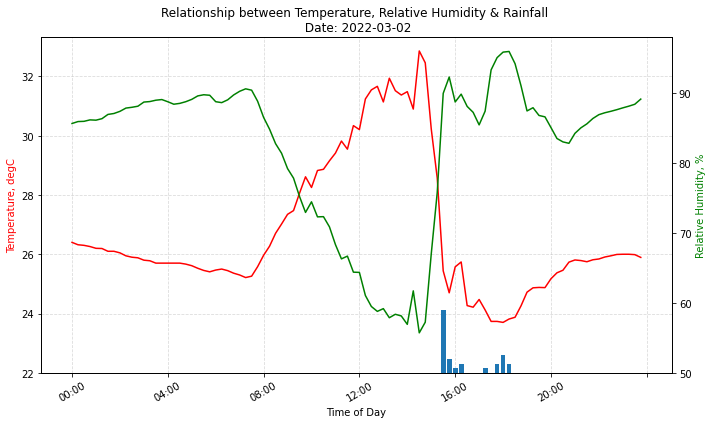

In [9]:
def weather_daily(df, read_data = False):
    
    filepath = '../data/02_weather_daily.csv'
    
    if read_data == True:
        weather_daily = pd.read_csv(filepath)
        weather_daily['timestamp'] = pd.to_datetime(weather_daily['timestamp'])
    else:
        # Filter out relevant 
        weather_daily = df.loc[:,['timestamp','station_id','name','temp','rh','wind_dir','wind_spd','rain']]
        weather_daily['timestamp'] = pd.to_datetime(weather_daily['timestamp'])

        # Promote station_id & timestamp
        weather_daily = weather_daily.sort_values(by = ['station_id','timestamp'])
        weather_daily = weather_daily.set_index(keys = ['station_id','timestamp'])
        
        # Resample - Hourly aggregated values
        weather_daily = weather_daily.groupby(['station_id','name']+[pd.Grouper(freq='15T', level=-1)]).agg({'temp': np.mean,
                                                                                                          'rh': np.mean,
                                                                                                          'wind_spd': np.mean,
                                                                                                           'wind_dir':np.mean,
                                                                                                          'rain':np.sum}
                                                                                                         )
        # Shift rain values, 30 min ahead for 30min prediction
        weather_daily['rain_shift30min'] = weather_daily.groupby(['station_id'])['rain'].shift(-2)
        weather_daily = weather_daily.reset_index()
        
        # Timestamp - get yearnum & monNum
        weather_daily['timestamp'] = pd.to_datetime(weather_daily['timestamp'])
        weather_daily['year'] = weather_daily['timestamp'].dt.year
        weather_daily['month'] = weather_daily['timestamp'].dt.month
        weather_daily['day'] = weather_daily['timestamp'].dt.day
        weather_daily['hour'] = weather_daily['timestamp'].dt.hour
        weather_daily['min'] = weather_daily['timestamp'].dt.minute
        
        

        # Save to csv
        weather_daily.to_csv(filepath, index = False)
    
    #################################################################################################################################
    plot_weather = weather_daily[weather_daily['station_id'] == 'S111']
    plot_weather = plot_weather.query('year == 2022 & month == 3 & day ==2 ')
    plot_weather['time'] = pd.to_datetime(plot_weather['timestamp']).dt.strftime('%H:%M')
    plot_weather = plot_weather.loc[:,['temp','rh','wind_spd','wind_dir','rain','time']]
    plot_weather = plot_weather.set_index('time')
    
    
    fig, ax1 = plt.subplots(figsize = (10,6))
    
    ax2 = ax1.twinx()
    ax3 = ax1.twinx()
    
    
    ax1.plot(plot_weather['temp'], label = 'Temperature, degC', c = 'Red')
    ax2.plot(plot_weather['rh'], label = 'Relative Humidity, %', c = 'Green')
    ax3.bar(x = plot_weather.index, height = plot_weather['rain'])
    
    ax1.set_xlabel('Time of Day')
    ax1.xaxis.set_major_locator(plt.MultipleLocator(16))
    ax1.tick_params(axis='x', labelrotation = 30)
    ax1.set_ylabel('Temperature, degC', color='r')
    ax2.set_ylabel('Relative Humidity, %', color='g')
    ax3.get_yaxis().set_visible(False)
    ax1.axis(ymin = 22)
    ax2.axis(ymin = 50)
    ax3.axis(ymax = 15)
    ax1.grid(axis = 'y', linestyle = '--', alpha = 0.45)
    ax1.grid(axis = 'x', linestyle = '--', alpha = 0.45)
    plt.title('Relationship between Temperature, Relative Humidity & Rainfall \n Date: 2022-03-02')
    fig.tight_layout()
    plt.show()
            
#     return weather_daily

temp_df = weather_daily(weather_data, read_data = True)


### 2.3 Concluding

In this notebook, we look at some relationships between the weather variables, and attempt to answer the reasons behind the observed weather phenomena. 
* we observe that some months have exceptionally high temperatures, and some with high humidities. 
* we also took a look at some of the areas with high and low rainfall, observing that the western areas tend to be wetter than the other areas in Singapore. 
* lastly, while this is not critical for modelling due to its <i>a posteriori</i> properties, we see a large drop in air temperature in the even of a rain. The relative humidity also rises during this period. 